# Variogram analysis and ordinary kriging for data in 2D (omni-directional)

Interpolate a data set in 2D, using ordinary kriging. Starting from a data set in 2D, the following is done:
- basic exploratory analysis: variogram cloud / variogram rose / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import grf
import geone.covModel as gcm
import geone.img as img
import geone.imgplot as imgplt
import geone.customcolors as ccol

## Preparation - build a data set in 2D

A data set in 2D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (isotropic) *reference* covariance model in 2D (class `covModel2D` from `geone.covModel`, see jupyter notebook `ex_grf_2d`).

In [2]:
cov_model_ref = gcm.CovModel2D(elem=[
    ('spherical', {'w':9.5, 'r':[50, 50]}), # elementary contribution (same ranges: isotropic)
    ('nugget', {'w':0.5})                     # elementary contribution
    ], alpha=0.0, name='ref model (isotropic)')

In [3]:
cov_model_ref

Covariance model 2D: (Name = ref model (isotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [50, 50]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angle: alpha = 0.0 deg.
   i.e.: the system Ox'y', supporting the axes of the model (ranges),
         is obtained from the system Oxy by applying a rotation of
         angle -alpha.

Generate a gaussian random field in 2D (see function `grf2D` from `geone.grf`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx, ny = 400, 420  # number of cells
dx, dy = 0.5, 0.5  # cell unit
ox, oy = 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = grf.grf2D(cov_model_ref, (nx, ny), (dx, dy), (ox, oy), nreal=1, printInfo=False) 
    # 3d-array of shape 1 x ny x nx

# Extract n points from the reference simulation
n = 50 # number of data points
ind = np.random.choice(nx*ny, size=n, replace=False) # indexes of extracted grid cells
ix = ind%nx  # indexes along x-axis
iy = ind//nx # indexes along y-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc)).T # array of coordinates of data points (shape: n x 2)
v = ref[0].reshape(-1)[ind] # value at data points

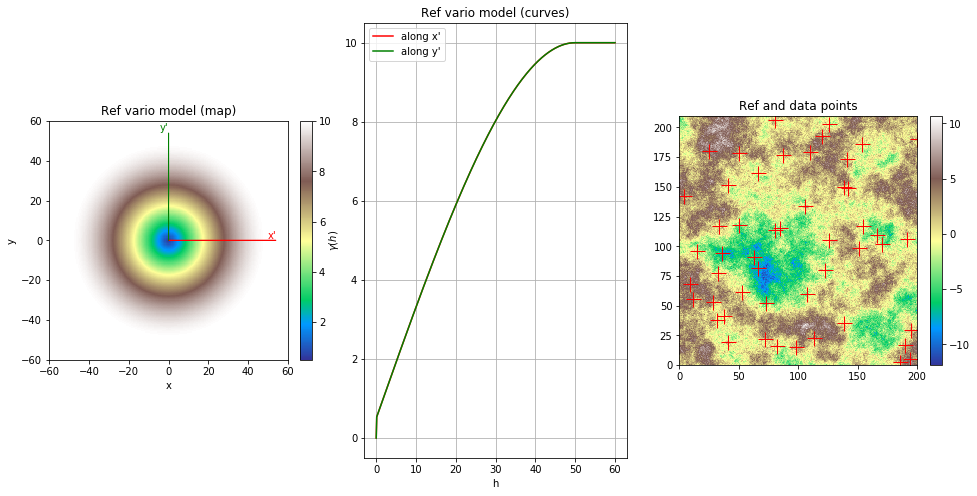

In [5]:
# Plot reference variogram model, reference simulation and data points
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
cov_model_ref.plot_model(vario=True, plot_map=True, plot_curves=False)
plt.title('Ref vario model (map)')
plt.subplot(1,3,2)
cov_model_ref.plot_model(vario=True, plot_map=False, plot_curves=True)
plt.title('Ref vario model (curves)')
plt.subplot(1,3,3)
im_ref = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=ref) # fill image (Img class from geone.img) for view
imgplt.drawImage2D(im_ref, cmap='terrain')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.title('Ref and data points')
plt.show()

## Start from a data set in 2D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

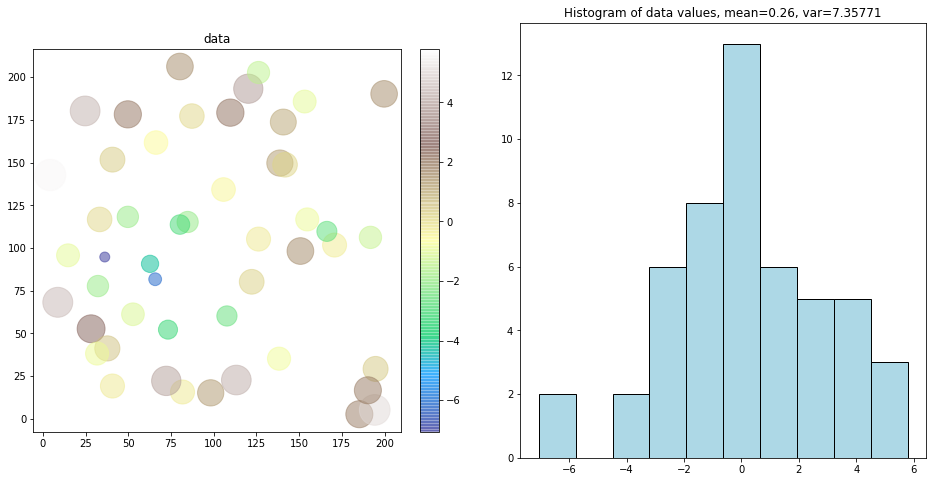

In [6]:
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
vmin, vmax = np.min(v), np.max(v) # min and max of data values
smin, smax = 100, 1000            # min and max size of points on plot
plot = plt.scatter(x[:,0], x[:,1], c=v, s=smin+(v-vmin)/(vmax-vmin)*(smax-smin), alpha=0.5, cmap='terrain')
ccol.add_colorbar(plot)
plt.axis('equal')
plt.title('data')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram rose

The function `variogramExp2D_rose` shows an experimental variogram for a data set in 2D in the form of a rose plot, *i.e.* the lags vectors between the pairs of data points are divided in classes according to length (radius) and angle from the x-axis counter-clockwise (*warning:* opposite sense to the sense given by angle in definition of a covariance model in 2D).

The keyword argument `r_max` allows to specify a maximal length of 2D-lag vector between a pair of data points for being integrated in the variogram rose plot. The number of classes for radius (length) can be specified by the keyword argument `r_ncla`, and the number of classes for angle for half of the whole disk (rose plot is symmetric with respect to the origin) can be specified by the keyword argument `phi_ncla`.

This function can be useful to check a possible anisotropy.

Mean of empty slice.
invalid value encountered in double_scalars


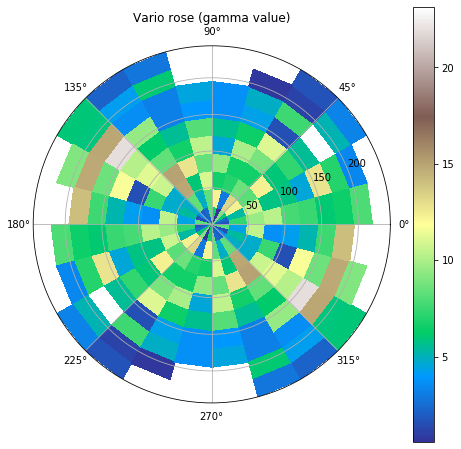

In [7]:
gcm.variogramExp2D_rose(x, v, figsize=(8,8))
plt.show()

For plotting a variogram rose in a multiple axes figure, proceed as follows.

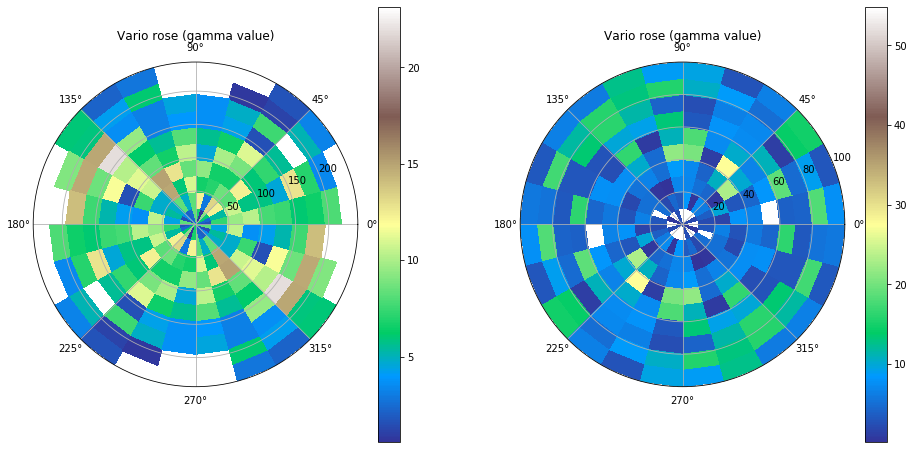

In [8]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(1,2,1, projection='polar')
gcm.variogramExp2D_rose(x, v, set_polar_subplot=False)

ax = fig.add_subplot(1,2,2, projection='polar')
gcm.variogramExp2D_rose(x, v, r_max=100, set_polar_subplot=False)

plt.show()

As no anisotropy is visible, an omni-directional covariance / variogram model could be used.

### Omni-directional variogram cloud
The function `variogramCloud1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

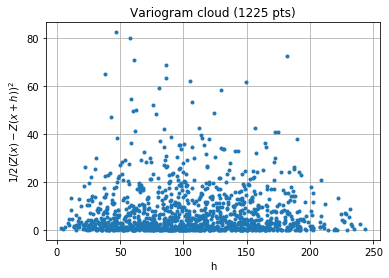

In [9]:
h, g, npair = gcm.variogramCloud1D(x, v)
plt.show()

### Omni-directional experimental variogram
The function `variogramExp1D` is used (see jupyter notebook `ex_vario_analysis_data1D`).

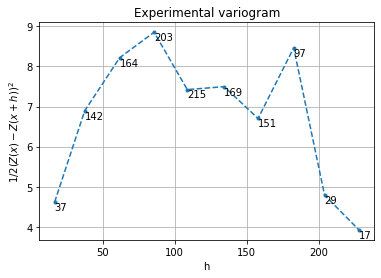

In [10]:
hexp, gexp, cexp = gcm.variogramExp1D(x, v)
# hexp, gexp, cexp = gcm.variogramExp1D(x, v, variogramCloud=(g, h, npair)) # equivalent (x, v not used) 
plt.show()

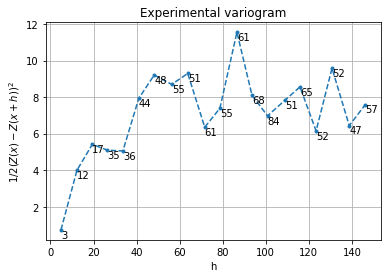

In [11]:
hexp, gexp, cexp = gcm.variogramExp1D(x, v, hmax=150, ncla=20)
plt.show()

### Omni-directional model fitting
The function `covModel1D_fit` is used to fit a covariance model in 1D (class `covModel1D`) (see jupyter notebook `ex_vario_analysis_data1D`).

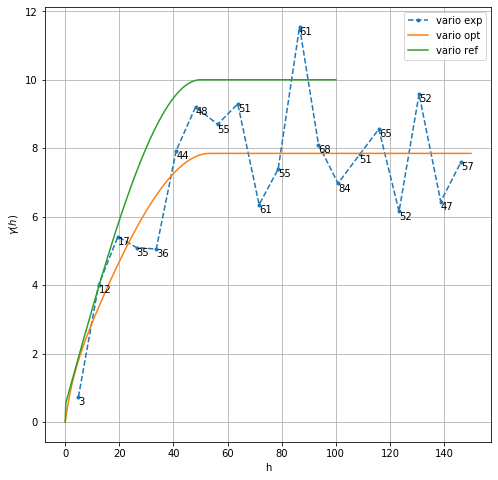

Covariance model 1D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 5.46036949281688e-07,  r = 47.748470166218404
   Elementary contribution 1: type : spherical
      parameters:  w = 6.799950451990619,  r = 53.404598899456744
   Elementary contribution 2: type : exponential
      parameters:  w = 1.0486152490850766,  r = 8.178146840560968
   Elementary contribution 3: type : nugget
      parameters:  w = 0.0002349408569545194

In [12]:
cov_model_to_optimize = gcm.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
         ], name='')

cov_model_opt, popt = gcm.covModel1D_fit(x, v, cov_model_to_optimize, hmax=200,
                                         bounds=([ 0,   0,  0,   0,  0,   0,  0],  # min value for param. to fit
                                                 [20, 100, 20, 100, 20, 100, 20]), # max value for param. to fit
                                         make_plot=False)
plt.figure(figsize=(8,8))
gcm.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=150, label='vario opt') # cov. model in 1D
cov_model_ref.plot_model_one_curve(vario=True, hmax=100, label='vario ref') # cov. model in 2D
plt.legend()
plt.show()
cov_model_opt

### Cross-validation of covariance model by leave-one-out error (based on ordinary kriging)
The function `cross_valid_loo_ok` makes a cross-validation test by leave-one-out (LOO) error. 

For a given a data set (in 2D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

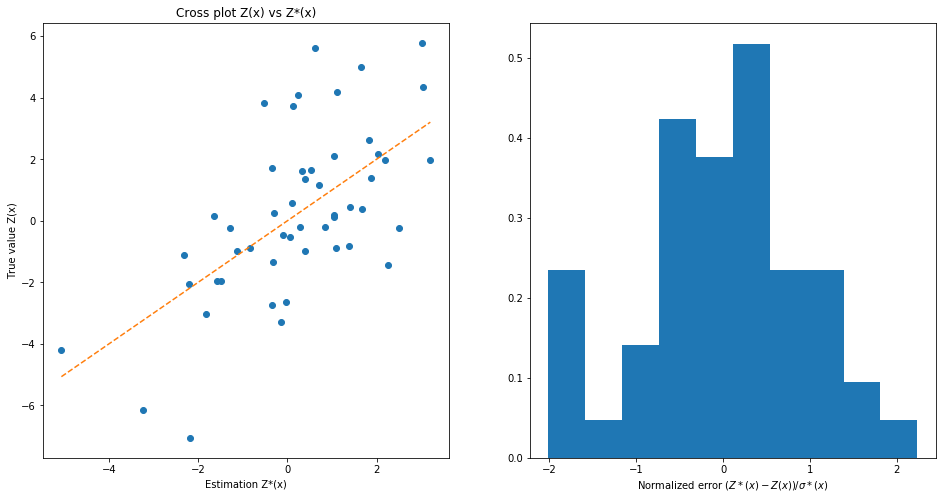

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


In [13]:
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))

### Data interpolation by ordinary kriging
The function `ordinary_kriging(x, v, xu, cov_model)` returns the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`.

For a given a data set (in 2D) and a covariance model in 1D, this latter defines an omni-directional covariance model.

For data in 2D:
- `x`: 2-dimensional array of shape `(n, 2)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 2)` location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, (ordinary) kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, (ordinary) kriging standard deviation at location `xu`.

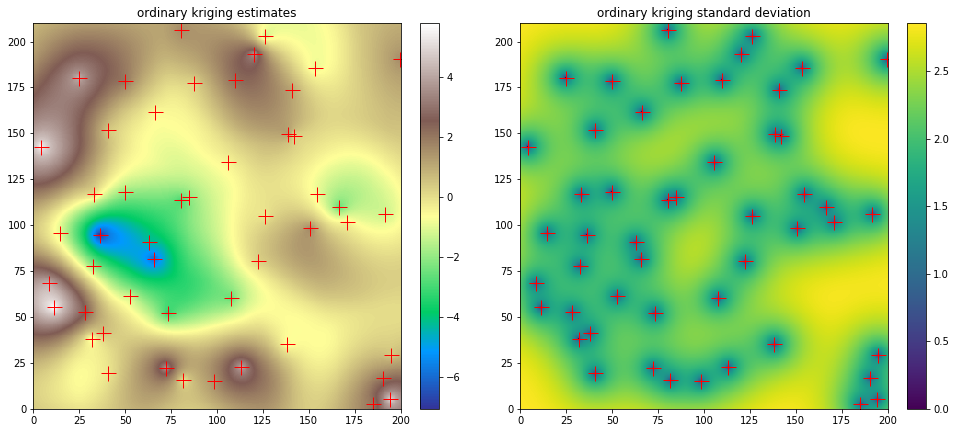

In [14]:
# Define points xu where to interpolate
# ... location of the 2D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
xxcu, yycu = np.meshgrid(xcu, ycu)
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1))).T # 2-dimensional array of shape nx*ny x 2

# Ordinary kriging
vu, vu_std = gcm.ordinary_kriging(x, v, xu, cov_model_opt)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: ordinary kriging estimates
#   variable 1: ordinary kriging standard deviation
im_ok = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
imgplt.drawImage2D(im_ok, iv=0, cmap='terrain', title='ordinary kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.subplot(1,2,2)
imgplt.drawImage2D(im_ok, iv=1, cmap='viridis', title='ordinary kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.show()

### Simple kriging (comparison)
Assuming the data (variable) stationary and specifying a constant mean (computed on the data set), the function `krige2D` (from `geone.grf` module, see jupyter notebook `ex_grf_2d`) can be used to compute simple krging estimates and standard deviation.

As the function `krige2D` requires a covariance model in 2D (class `covModel2D`), the omni-directional covariance model considered (model in 1D) must be converted first.

**Note:** a varying mean can also be specified.

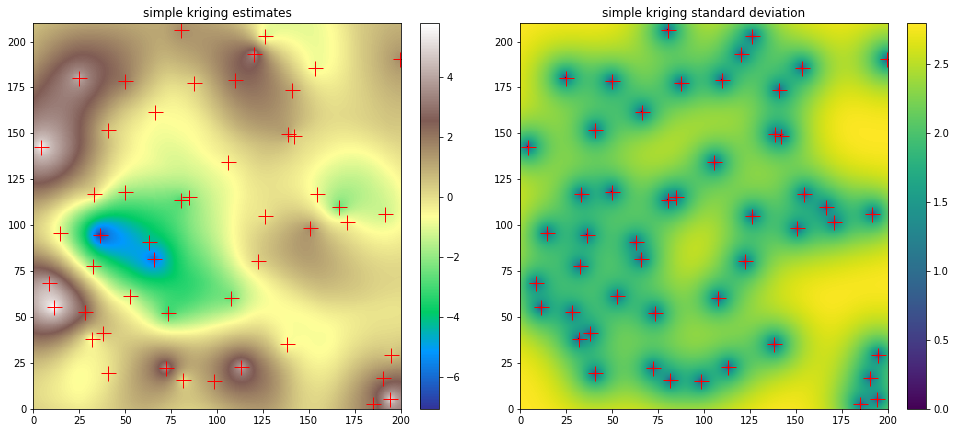

In [15]:
cov_model_opt2D = gcm.covModel1D_to_covModel2D(cov_model_opt) # convert model 1D in 2D
vu_sk, vu_sk_std = grf.krige2D(x, v, cov_model_opt2D, (nx, ny), (dx, dy), (ox, oy), 
                               mean=np.mean(v), printInfo=False)

# Fill image (Img class from geone.img) for view
#   variable 0: simple kriging estimates
#   variable 1: simple kriging standard deviation
im_sk = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu_sk, vu_sk_std)))

# Plot
plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
imgplt.drawImage2D(im_sk, iv=0, cmap='terrain', title='simple kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.subplot(1,2,2)
imgplt.drawImage2D(im_sk, iv=1, cmap='viridis', title='simple kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.show()

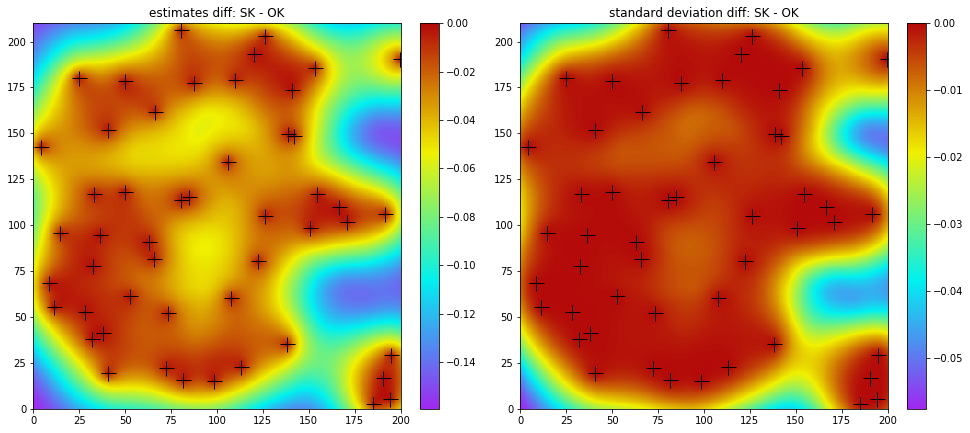

In [16]:
# Plot difference of simple kriging - ordinary kriging
im_diff = img.copyImg(im_sk)
im_diff.val = im_sk.val - im_ok.val

plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
imgplt.drawImage2D(im_diff, iv=0, title='estimates diff: SK - OK')
plt.plot(x[:,0], x[:,1], 'k+', markersize=15)
plt.subplot(1,2,2)
imgplt.drawImage2D(im_diff, iv=1, title='standard deviation diff: SK - OK')
plt.plot(x[:,0], x[:,1], 'k+', markersize=15)
plt.show()

### Conditional simulation using the function `grf2D`
Specifying the same mean, the function `grf2D` (from `geone.grf` module, see jupyter notebook `ex_grf_2d`) can be used to generate conditional realizations (based on simple kriging).

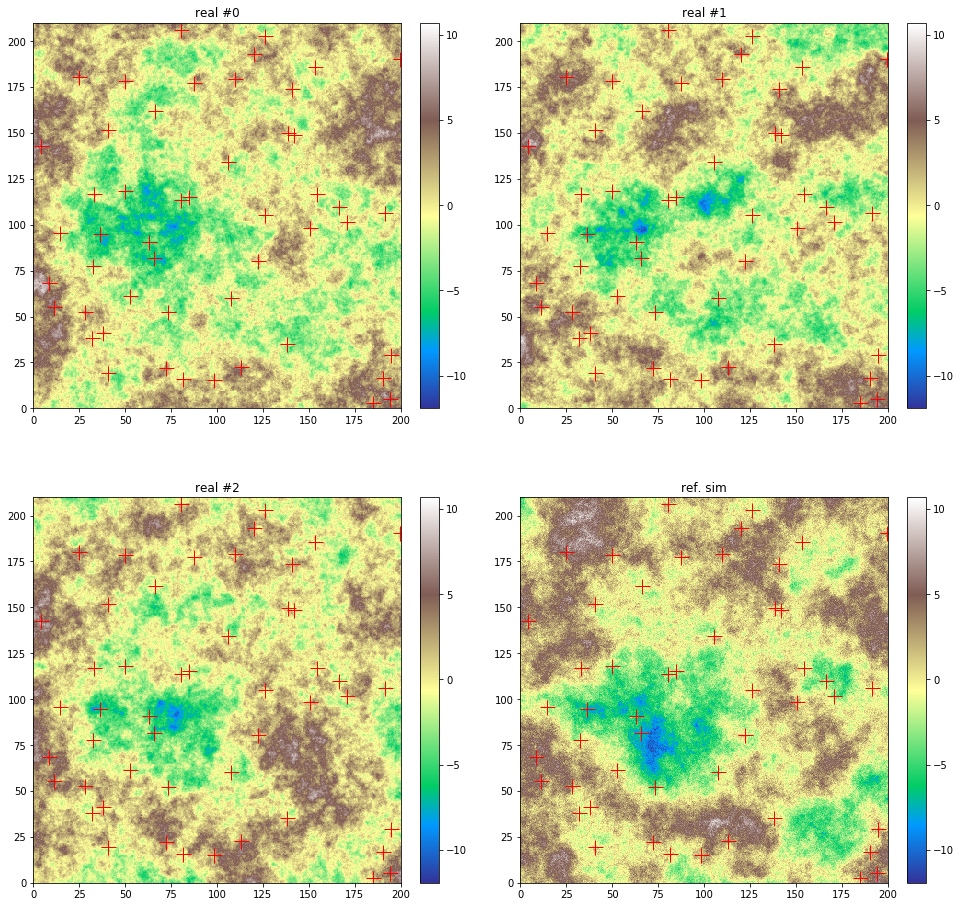

In [17]:
# Simulation
np.random.seed(293)
nreal = 3
sim = grf.grf2D(cov_model_opt2D, (nx, ny), (dx, dy), (ox, oy), 
                x=x, v=v, nreal=nreal, printInfo=False) # 3d-array of shape nreal x ny x nx

# Fill image (Img class from geone.img) for view
im_sim = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim)

im_vmin = min(np.min(im_sim.vmin()), im_ref.vmin()[0]) # min over all real and ref. sim
im_vmax = max(np.max(im_sim.vmax()), im_ref.vmax()[0]) # max over all real and ref. sim

# Plot
plt.subplots(2,2, figsize=(16,16))
for i in range(3):
    plt.subplot(2,2,i+1)
    imgplt.drawImage2D(im_sim, iv=i, cmap='terrain', vmin=im_vmin, vmax=im_vmax, title='real #{}'.format(i))
    plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,2,4)
imgplt.drawImage2D(im_ref, cmap='terrain', vmin=im_vmin, vmax=im_vmax, title='ref. sim')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.show()

Note that the nugget weight in the optimal covariance model found is near zero, whereas in the reference covariance model, its value is 0.5. As a matter of fact, the reference simulation above is more "noisy". To ensure a larger nugget in the optimal covariance model, a minimal bound can be set accordingly for this parameter and passed to the function `covModel1D_fit`.